# Ball detection system

In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import warnings
import time
import ast
import serial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from collections import Counter


# Suppress specific KMeans warning (UserWarning related to MKL memory leak)
warnings.filterwarnings("ignore", category=UserWarning, message=".*KMeans is known to have a memory leak.*")


'''
This code detects the field and balls from the main camera.
To use setup, go to settings.txt and set: Setup: 1.
When booted in this mode then you can use trackbars to set the parameters for the: white balls, orange balls, field, ball size.
When satisfied with the parameters, click 's' to go to the next state.
When everythin has been setup you will enter final state where both ball detection and field detection are running. In this state you can also press 'p'
to print out the current balls detected.

Whenever you quit using 'q' the program will save your used parameters for next time in the settings.txt

When run it usually takes 1-2 min for camera to open...

The field updates 1 time every half second. This can be changed in the code (maybe add to settings file later)
'''

###########################################################################
# Functions
###########################################################################

# Function to do nothing (for trackbars)
def nothing(x):
    pass

# Ball detection function
def detect_ball(image, hsv, lower_white, upper_white, lower_orange, upper_orange, 
                param1, param2, min_radius, max_radius, min_x, max_x, min_y, max_y, num_cells):
    """Detects both white and orange balls and maps them to grid coordinates."""
    
    # Detect white ball
    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    blurred_white = cv2.GaussianBlur(mask_white, (9, 9), 2)
    circles_white = cv2.HoughCircles(blurred_white, cv2.HOUGH_GRADIENT, 1, 20, param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)

    # Detect orange ball
    mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
    blurred_orange = cv2.GaussianBlur(mask_orange, (9, 9), 2)
    circles_orange = cv2.HoughCircles(blurred_orange, cv2.HOUGH_GRADIENT, 1, 20, param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)

    detected_balls = []
    
    if circles_white is not None:
        circles_white = np.uint16(np.around(circles_white))
        for (x, y, r) in circles_white[0, :]:
            cv2.circle(image, (x, y), r, (255, 255, 255), 2)  # White circle
            
            # Map ball to grid
            grid_col = int(((x - min_x) / (max_x - min_x)) * num_cells)
            grid_row = int(((y - min_y) / (max_y - min_y)) * num_cells)
            

            ball_position = (grid_col, grid_row)
            cv2.putText(image, f"w({grid_col}, {grid_row})", (x + 10, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            detected_balls.append(('white', ball_position))

    if circles_orange is not None:
        circles_orange = np.uint16(np.around(circles_orange))
        for (x, y, r) in circles_orange[0, :]:
            cv2.circle(image, (x, y), r, (0, 165, 255), 2)  # Orange circle
            
            # Map ball to grid
            grid_col = int(((x - min_x) / (max_x - min_x)) * num_cells)
            grid_row = int(((y - min_y) / (max_y - min_y)) * num_cells)

            ball_position = (grid_col, grid_row)
            cv2.putText(image, f"o({grid_col}, {grid_row})", (x + 10, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            detected_balls.append(('orange', ball_position))

    return image, detected_balls

def detect_eggs(image, hsv, lower_white, upper_white, min_size=10000, max_size=30000):
    """
    Detects large white eggs (oval shapes) in a frame.
    Returns:
        egg_positions: List of ((center_x, center_y), (width, height), angle) for each egg
    """
    mask = cv2.inRange(hsv, lower_white, upper_white)
    
    # Morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    egg_positions = []
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_size < area < max_size and len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            (center, axes, angle) = ellipse
            width, height = axes
            
            # Draw visualization
            cv2.ellipse(image, ellipse, (0, 0, 255), 3)
            center_x, center_y = map(int, center)
            cv2.circle(image, (center_x, center_y), 5, (0, 255, 0), -1)
            cv2.putText(image, f"EGG {int(width)}x{int(height)}", 
                       (center_x + 20, center_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            egg_positions.append(ellipse)
    
    return image, egg_positions

def detect_field_orange(image, hsv, lower_orange_field, upper_orange_field, show_mask):
    """Detects the field using orange boundary markers, finds corners, and updates the grid."""
    
    # Detect field boundaries (orange color)
    mask = cv2.inRange(hsv, lower_orange_field, upper_orange_field)
    
    if show_mask == True:
        cv2.namedWindow("Mask", cv2.WINDOW_NORMAL)
        cv2.imshow("Mask", mask)

    # Edge detection
    edges = cv2.Canny(mask, 50, 150)
    dilated_edges = cv2.dilate(edges, None, iterations=1)
    lines = cv2.HoughLinesP(dilated_edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)

    # Find intersections
    intersection_points = []
    detected_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            detected_lines.append(((x1, y1), (x2, y2)))

        # Compute intersections between every pair of detected lines
        for i in range(len(detected_lines)):
            for j in range(i + 1, len(detected_lines)):
                x1, y1 = detected_lines[i][0]
                x2, y2 = detected_lines[i][1]
                x3, y3 = detected_lines[j][0]
                x4, y4 = detected_lines[j][1]

                # Compute intersection using the line intersection formula
                denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                if denominator != 0:
                    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
                    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator
                    intersection_points.append((int(intersect_x), int(intersect_y)))

    # Update field boundaries immediately if valid intersections are found
    if intersection_points:
        points = np.array(intersection_points)
        valid_points = points[
            (points[:, 0] > 0) & (points[:, 0] < image.shape[1]) &
            (points[:, 1] > 0) & (points[:, 1] < image.shape[0])
        ]
        if len(valid_points) > 3:
            kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
            kmeans.fit(valid_points)
            cluster_centers = kmeans.cluster_centers_

            # Sort corners into Top-left, Top-right, Bottom-left, Bottom-right
            sorted_corners = sorted(cluster_centers, key=lambda c: (c[1], c[0]))
            top_two = sorted(sorted_corners[:2], key=lambda c: c[0])
            bottom_two = sorted(sorted_corners[2:], key=lambda c: c[0])
            corners = {
                "Top Left": top_two[0],
                "Top Right": top_two[1],
                "Bottom Left": bottom_two[0],
                "Bottom Right": bottom_two[1],
            }

            # Define field boundaries
            min_x = min(c[0] for c in cluster_centers)
            max_x = max(c[0] for c in cluster_centers)
            min_y = min(c[1] for c in cluster_centers)
            max_y = max(c[1] for c in cluster_centers)

            cell_width = (max_x - min_x) / num_cells
            cell_height = (max_y - min_y) / num_cells

            return corners, min_x, max_x, min_y, max_y, cell_width, cell_height

    return None  # No update to field boundaries if conditions are not met

def detect_field_green_corners(hsv, lower_green, upper_green, show_mask=False, draw_grid=False, frame=None):
    """Detects the field using green markers and optionally draws grid/corners on the frame."""
    
    mask = cv2.inRange(hsv, lower_green, upper_green)

    if show_mask:
        cv2.namedWindow("Mask", cv2.WINDOW_NORMAL)
        cv2.imshow("Mask", mask)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    marker_centers = []
    min_area = 100
    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                marker_centers.append((cX, cY))

    if len(marker_centers) < 4:
        return None

    marker_centers = np.array(marker_centers)

    if len(marker_centers) > 4:
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
        kmeans.fit(marker_centers)
        centers = kmeans.cluster_centers_
    else:
        centers = marker_centers

    sorted_corners = sorted(centers, key=lambda c: (c[1], c[0]))
    top_two = sorted(sorted_corners[:2], key=lambda c: c[0])
    bottom_two = sorted(sorted_corners[2:], key=lambda c: c[0])
    corners = {
        "Top Left": top_two[0],
        "Top Right": top_two[1],
        "Bottom Left": bottom_two[0],
        "Bottom Right": bottom_two[1],
    }

    min_x = min(centers[:, 0])
    max_x = max(centers[:, 0])
    min_y = min(centers[:, 1])
    max_y = max(centers[:, 1])

    cell_width = (max_x - min_x) / num_cells
    cell_height = (max_y - min_y) / num_cells

    # Optionally draw on the frame
    if draw_grid and frame is not None:
        draw_field_overlay(frame, corners, min_x, max_x, min_y, max_y, cell_width, cell_height, num_cells, start_pos)

    return corners, min_x, max_x, min_y, max_y, cell_width, cell_height


def save_settings(filename="settings.txt"):
    with open(filename, "w") as f:

        # Write comments at the top of the file
        f.write("# This file is used for the settings in the program\n")
        f.write("# It stores the last used values whenever you quit the program with 'q'\n")
        f.write("# You can also change these upon startup if needed\n\n")
        
        f.write("# If you want to use these values and not use the setup, Then set: Setup: 0\n")
        f.write("# If you want to use the setup and pick these values with the trackbars: Setup: 1\n\n")


        f.write(f"Setup: {setup}\n")
        f.write(f"Using Green Corners: {using_green_corners}\n")

        f.write(f"Lower White HSV: {lower_white.tolist()}\n")
        f.write(f"Upper White HSV: {upper_white.tolist()}\n")
        f.write(f"Lower Orange HSV: {lower_orange.tolist()}\n")
        f.write(f"Upper Orange HSV: {upper_orange.tolist()}\n")
        f.write(f"Field Lower Orange HSV: {lower_orange_field.tolist()}\n")
        f.write(f"Field Upper Orange HSV: {upper_orange_field.tolist()}\n")
        f.write(f"Field Lower Green HSV: {lower_green_field.tolist()}\n")
        f.write(f"Field Upper Green HSV: {upper_green_field.tolist()}\n")
        f.write(f"Num Cells: {num_cells}\n")
        f.write(f"Param1: {param1}\n")
        f.write(f"Param2: {param2}\n")
        f.write(f"Min Radius: {min_radius}\n")
        f.write(f"Max Radius: {max_radius}\n")

def load_settings_from_file(filename="settings.txt"):
    settings = {}
    try:
        with open(filename, "r") as file:
            lines = file.readlines()

            for line in lines:
                line = line.strip()

                # Skip comments and empty lines
                if not line or line.startswith("#"):
                    continue

                # Split key-value pairs
                key, value = line.split(":")
                key = key.strip()
                value = value.strip()

                # Convert list values using ast.literal_eval for safety
                if value.startswith("[") and value.endswith("]"):
                    settings[key] = ast.literal_eval(value)  # safely evaluate the list
                else:
                    # Convert to integer if possible
                    try:
                        settings[key] = int(value)
                    except ValueError:
                        settings[key] = value  # Otherwise, it's a string (this is unlikely for your settings)
    except Exception as e:
        print(f"Error reading settings from file: {e}")

    return settings

def is_close(position1, position2, threshold=2):
    return abs(position1[0] - position2[0]) <= threshold and abs(position1[1] - position2[1]) <= threshold

def update_balls(detected_balls):
    """Update global list of balls if a ball has moved too far or if new balls are detected."""
    global ball_dict
    
    new_ball_dict = []  # Will hold the updated balls list
    detected_set = set(tuple(ball) for ball in detected_balls)  # Set of detected balls for faster lookup

    # Step 1: Compare each ball in the global list to the detected balls
    for existing_color, existing_position in ball_dict:
        matched = False
        for detected_color, detected_position in detected_balls:
            if is_close(existing_position, detected_position):
                new_ball_dict.append((existing_color, existing_position))  # Ball didn't move, keep it
                detected_set.discard((detected_color, detected_position))  # Mark as matched
                matched = True
                break
        if not matched:
            pass  # Ball has moved, do not add it back

    # Step 2: Add new balls that were detected but not already in the global list
    for detected_color, detected_position in detected_set:
        new_ball_dict.append((detected_color, detected_position))  # Add new ball at the end

    # Step 3: Sort white balls by distance to a reference point
    cx, cy = 15, 15 # Reference point

    white_balls = sorted(
        [ball for ball in new_ball_dict if ball[0] == 'white'],
        key=lambda b: (b[1][0] - cx) ** 2 + (b[1][1] - cy) ** 2
    )


    # Step 4: Ensure the orange ball is always at the beginning of the list
    orange_ball = [ball for ball in new_ball_dict if ball[0] == 'orange']
    other_balls = [ball for ball in new_ball_dict if ball[0] != 'orange' and ball[0] != 'white']

    # Combine all in the correct order
    ball_dict = orange_ball + white_balls + other_balls

def create_trackbars_hsv(window_name, lower_vals, upper_vals):
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.moveWindow(window_name, 0, 0)

    cv2.createTrackbar("Hue min", window_name, lower_vals[0], 180, nothing)
    cv2.createTrackbar("Hue max", window_name, upper_vals[0], 180, nothing)
    cv2.createTrackbar("Sat min", window_name, lower_vals[1], 255, nothing)
    cv2.createTrackbar("Sat max", window_name, upper_vals[1], 255, nothing)
    cv2.createTrackbar("Bright min", window_name, lower_vals[2], 255, nothing)
    cv2.createTrackbar("Bright max", window_name, upper_vals[2], 255, nothing)

def get_trackbar_pos_hsv(window_name):
    lower_h = cv2.getTrackbarPos("Hue min", window_name)
    upper_h = cv2.getTrackbarPos("Hue max", window_name)
    lower_s = cv2.getTrackbarPos("Sat min", window_name)
    upper_s = cv2.getTrackbarPos("Sat max", window_name)
    lower_v = cv2.getTrackbarPos("Bright min", window_name)
    upper_v = cv2.getTrackbarPos("Bright max", window_name)

    lower_vals = np.array([lower_h, lower_s, lower_v])
    upper_vals = np.array([upper_h, upper_s, upper_v])
    return lower_vals, upper_vals

def create_trackbars_ball(window_name, param1_val, param2_val, min_radius_val, max_radius_val):
    cv2.namedWindow(window_name, cv2.WINDOW_GUI_NORMAL)
    cv2.moveWindow(window_name, 0, 0)

    cv2.createTrackbar("p1", window_name, param1_val, 50, nothing)
    cv2.createTrackbar("p2", window_name, param2_val, 50, nothing)
    cv2.createTrackbar("Ball min", window_name, min_radius_val, 50, nothing)
    cv2.createTrackbar("Ball max", window_name, max_radius_val, 50, nothing)

def get_trackbar_pos_ball(window_name):
    p1 = max(1, cv2.getTrackbarPos("p1", window_name))
    p2 = max(1, cv2.getTrackbarPos("p2", window_name))
    min_r = cv2.getTrackbarPos("Ball min", window_name)
    max_r = cv2.getTrackbarPos("Ball max", window_name)
    return p1, p2, min_r, max_r


def detect_blue_object(image, hsv, lower_blue, upper_blue, min_x, max_x, min_y, max_y, num_cells):
    """Detects blue object and maps it to grid coordinates, returning the positions of the blue objects."""
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    blue_mask = cv2.erode(blue_mask, None, iterations=2)
    blue_mask = cv2.dilate(blue_mask, None, iterations=2)
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    blue_positions = []  # List to store the blue object's grid positions

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            if radius > 5:
                x, y = int(x), int(y)
                cv2.circle(image, (x, y), int(radius), (255, 0, 0), 2)

                # Map to grid
                grid_col = int(((x - min_x) / (max_x - min_x)) * num_cells)
                grid_row = int(((y - min_y) / (max_y - min_y)) * num_cells)

                cv2.putText(image, f"b({grid_col}, {grid_row})", (x + 10, y - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

                # Store the position in the list
                blue_positions.append((grid_col, grid_row))

    return image, blue_positions

def move_one_step_towards_target_x(current_pos, target_pos, motor_step_scale_x):
    if current_pos < target_pos:
        return motor_step_scale_x  # Move right
    elif current_pos > target_pos:
        return -motor_step_scale_x  # Move left
    else:
        return 0  # Already at target

def update_x_pos(blue_x, target_x, x_pos, motor_step_scale_x):
    """
    Updates x_pos based on the visual distance between blue_x and target_x,
    scaled by motor_step_scale to convert visual units into motor steps.

    Args:
        blue_x (float): current detected position of the arm.
        target_x (float): desired position on the grid.
        x_pos (int): current motor position command.
        motor_step_scale (float): scale factor for converting visual units to motor steps.

    Returns:
        int: updated motor position (x_pos).
    """
    delta = target_x - blue_x
    motor_steps = int(round(delta * motor_step_scale_x))
    return x_pos + motor_steps

def update_y_pos(blue_y, target_y, y_pos, motor_step_scale_y):
    """
    Updates y_pos based on the visual distance between blue_y and target_y,
    scaled by motor_step_scale_y to convert visual units into motor steps.

    Args:
        blue_y (float): current detected position of the arm.
        target_y (float): desired position on the grid.
        y_pos (int): current motor position command.
        motor_step_scale_y (float): scale factor for converting visual units to motor steps.

    Returns:
        int: updated motor position (y_pos).
    """
    delta = target_y - blue_y
    motor_steps = delta * motor_step_scale_y
    return y_pos - motor_steps



def draw_field_overlay(frame, corners, min_x, max_x, min_y, max_y, cell_width, cell_height, num_cells, start_pos):
    """Draws the field corners, grid, and boundary on the given frame."""
    
    # Draw yellow dots at the corners
    for corner_name, corner_coords in corners.items():
        cv2.circle(frame, (int(corner_coords[0]), int(corner_coords[1])), 7, (0, 255, 255), -1)

    # Draw grid lines
    for i in range(1, num_cells):
        x = min_x + i * cell_width
        y = min_y + i * cell_height
        cv2.line(frame, (int(x), int(min_y)), (int(x), int(max_y)), (255, 255, 255), 1)
        cv2.line(frame, (int(min_x), int(y)), (int(max_x), int(y)), (255, 255, 255), 1)

    # Draw outer rectangle
    cv2.rectangle(frame, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (0, 0, 0), 2)

    # === Draw center point ===
    center_x = min_x + num_cells/2 * cell_width
    center_y = min_y + num_cells/2 * cell_height
    cv2.circle(frame, (int(center_x), int(center_y)), 6, (0, 0, 255), -1)  # red dot for center

    # Draw starting point
    _, (start_x, start_y) = start_pos
    pos_x = min_x + start_x * cell_width
    pos_y = min_y + start_y * cell_height
    cv2.circle(frame, (int(pos_x), int(pos_y)), 3, (255, 0, 255), -1)  # Pink dot for start

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Step 1: Prepare your data
# Replace with your actual data
measured = np.array([
    [13,16], [19,16], [24,16], [28,16], [31,16], [35,16], [42,15], [44,15], [47,15],
    [46,21], [42,21], [39,21], [36,22], [33,22], [30,21], [26,22], [22,21], [19,21], [16,21], [12,21],
    [12,26], [16,26], [19,26], [22,26], [25,26], [30,26], [33,26], [36,27], [39,26], [42,27], [45,27], [48,27],
    [48,31], [45,31], [42,31], [38,31], [35,31], [33,32], [29,31], [26,31], [22,31], [19,31], [16,31], [12,31], [10,31],
    [10,36], [13,36], [16,36], [19,37], [24,36], [27,38], [31,39], [34,39], [37,39], [41,40], [44,40], [47,40],
    [47,44], [43,44], [39,43], [34,43], [30,43], [26,43], [21,42], [16,43], [12,43], [10,43],
    [10,48], [13,48], [16,47], [21,47], [24,48], [27,48], [31,48], [35,48], [40,49], [43,49], [47,49]
])

actual = np.array([
    [7,6], [16,6], [23,6], [28,6], [32,6], [39,6], [48,5], [52,6], [56,5],
    [55,12], [47,13], [44,13], [41,14], [35,14], [31,14], [25,14], [20,14], [14,14], [10,14], [4,14],
    [4,21], [9,21], [15,21], [18,21], [23,21], [31,21], [37,21], [41,21], [45,22], [48,22], [54,22], [57,22],
    [57,28], [53,28], [48,28], [44,28], [39,28], [35,28], [29,28], [25,28], [20,28], [14,28], [9,28], [4,28], [1,28],
    [1,36], [5,36], [10,36], [15,37], [22,37], [27,39], [33,40], [37,41], [42,41], [47,41], [52,42], [56,42],
    [57,48], [51,48], [45,46], [38,46], [30,46], [23,46], [16,46], [10,46], [4,46], [1,46],
    [0,54], [5,55], [10,55], [15,55], [20,54], [25,54], [33,54], [38,54], [46,54], [50,54], [56,56]
])

# Step 2: Fit 2D polynomial model
degree = 3  # Try degree=2 or 3; adjust for overfitting/underfitting
poly = PolynomialFeatures(degree=degree)

# Transform inputs
X_poly = poly.fit_transform(measured)

# Fit separate regressions for x and y
model_x = LinearRegression().fit(X_poly, actual[:, 0])
model_y = LinearRegression().fit(X_poly, actual[:, 1])

# Step 3: Define prediction function
def correct_position(measured_x, measured_y):
    input_poly = poly.transform([[measured_x, measured_y]])
    corrected_x = model_x.predict(input_poly)[0]
    corrected_y = model_y.predict(input_poly)[0]
    return corrected_x, corrected_y

# Example usage
pred_x, pred_y = correct_position(22, 26)
print("Corrected:", round(pred_x, 2), round(pred_y, 2))




import math

def sort_by_shortest_path(ball_list):
    """
    Returns a full path: 
    Start (3,3) → Orange Ball → Goal (10,30) → Sorted White Balls → Goal

    Args:
        ball_list (list): List of (color, (grid_x, grid_y)) tuples.

    Returns:
        list: Ordered path list of (label, (grid_x, grid_y)) tuples.
    """

    goal = (13.5, 30.5)

    # Separate balls by color
    orange_balls = [ball for ball in ball_list if ball[0] == "orange"]
    white_balls = [ball for ball in ball_list if ball[0] == "white"]

    if not orange_balls:
        print("⚠️ No orange ball found.")
        return []

    orange_pos = orange_balls[0][1]  # Assume one orange ball

    # Sort white balls starting from goal (nearest neighbor)
    unsorted = white_balls.copy()
    sorted_whites = []
    current_pos = goal

    while unsorted:
        closest = min(unsorted, key=lambda b: math.dist(current_pos, b[1]))
        sorted_whites.append(closest)
        current_pos = closest[1]
        unsorted.remove(closest)

    # Build the full path
    path = [
        ('orange', orange_pos),
        ('goal', goal),
    ] + sorted_whites + [('goal', goal)]

    return path


def draw_path_on_frame(frame, path, min_x, min_y, cell_width, cell_height):
    """
    Draws the route path on the frame, converting grid positions to screen coordinates.
    Uses arrows instead of numbers to indicate direction.
    """

    for i in range(len(path) - 1):
        _, grid_p1 = path[i]
        _, grid_p2 = path[i + 1]

        screen_p1 = (
            int(min_x + (grid_p1[0] + 0.5) * cell_width),
            int(min_y + (grid_p1[1] + 0.5) * cell_height)
        )
        screen_p2 = (
            int(min_x + (grid_p2[0] + 0.5) * cell_width),
            int(min_y + (grid_p2[1] + 0.5) * cell_height)
        )

        # Draw arrow from p1 to p2
        cv2.arrowedLine(frame, screen_p1, screen_p2, (25, 25, 25), 2, tipLength=0.1, line_type=cv2.LINE_AA)

        # Optionally mark each node
        cv2.circle(frame, screen_p1, 5, (200, 200, 200), -1)

    # Final point
    _, last_grid = path[-1]
    last_screen = (
        int(min_x + last_grid[0] * cell_width),
        int(min_y + last_grid[1] * cell_height)
    )
    cv2.circle(frame, last_screen, 5, (0, 0, 0), -1)

def go_to_target_x(target_x, debug=False):
    """
    Moves the X-axis toward the target X coordinate with one smooth G-code move.

    Args:
        target_x (float): Target X coordinate (grid units)
        debug (bool): If True, print debug messages

    Returns:
        True = target reached
    """
    global x_pos

    grid_delta = target_x - x_blue
    distance = abs(grid_delta)

    # Close enough — done
    if distance <= tolerance:
        if debug:
            print("[CONTROL] Target X reached.")
        return True

    # Convert target_x to motor position (mm or steps depending on your setup)
    target_x_pos = target_x * motor_step_scale_x

    # Plan full move
    speed = 100  # mm/min or whatever your firmware expects

    # Build G-code command
    gcode = f"G1 X{-target_x_pos:.3f} Y{x_pos:.3f} F{speed}\n"
    ser.write(gcode.encode())

    if debug:
        print(f"[CONTROL] Sending: {gcode.strip()}")

    # Estimate time to move — crude but works
    move_speed = speed / 60.0  # mm/sec
    estimated_time = distance / move_speed
    estimated_time = max(estimated_time, 0.05)  # minimum delay

    time.sleep(estimated_time)

    # Update our estimated position
    x_pos = target_x_pos

    return True


def go_to_target_y(target_y, debug=False):
    """
    Moves the Y-axis toward the target Y coordinate with adaptive speed and step size.

    Args:
        target_y (float): Target grid Y position.
        debug (bool): If True, prints debug output.

    Returns:
        True    → Target reached
        False   → Still moving
    """
    global controller_timer, motor_delay_y

    # Wait before next move
    time_elapsed = time.time() - controller_timer
    if time_elapsed < motor_delay_y:
        return False  # Not ready yet

    grid_delta = target_y - y_blue
    distance = abs(grid_delta)

    # Close enough to target
    if distance <= tolerance:
        if debug:
            print("[CONTROL] Target Y reached.")
        return True

    # Adaptive step size and speed based on distance
    if distance > 5:
        steps = 50
        speed = 20000  # fast
    elif distance > 2:
        steps = 30
        speed = 22000  # medium
    else:
        steps = 10
        speed = 25000  # slow

    direction = "UP" if grid_delta < 0 else "DOWN"

    if debug:
        print(f"[CONTROL] Moving {steps} steps {direction} at speed {speed} µs (ΔY: {grid_delta:.2f})")

    # Send motor command
    move_motor_y(steps=steps, speed_microseconds=speed, direction=direction)

    # Update controller timing
    controller_timer = time.time()

    return False  # Still moving




 


def go_to_target(target_x, target_y, debug=False):
    """
    Moves toward the target (x, y) using:
      - X and Y in G-code for X-axis movement
      - Z in G-code for Y-axis movement (vertical)

    Args:
        target_x (float): Desired X-axis coordinate (grid-based)
        target_y (float): Desired Y-axis coordinate (grid-based)
        debug (bool): Enable debug print

    Returns:
        True    → Target reached
        False   → Still moving
        "fail"  → Max attempts reached
    """
    global controller_active, controller_timer, controller_attempts
    global controller_delay, x_pos, y_pos

    time_elapsed = time.time() - controller_timer

    if time_elapsed >= controller_delay:
        if debug:
            print(f"\n[Control Attempt {controller_attempts + 1}]")
            print(f"  Current blue_x = {x_blue}, Target_x = {target_x}")
            print(f"  Current blue_y = {y_blue}, Target_y = {target_y}")
            print(f"  ΔX: {target_x - x_blue}, ΔY: {target_y - y_blue}")

        reached_x = abs(x_blue - target_x) <= tolerance
        reached_y = abs(y_blue - target_y) <= tolerance

        if reached_x and reached_y:
            if debug:
                print("[CONTROL] Target reached.")
            controller_active = False
            controller_delay = 0
            return True

        elif controller_attempts >= max_attempts:
            if debug:
                print("[CONTROL] Max attempts reached. Stopping.")
            controller_active = False
            controller_delay = 0
            return "fail"

        else:
            # Calculate steps
            motor_steps_x = (target_x - x_blue) * motor_step_scale_x
            motor_steps_y = (target_y - y_blue) * motor_step_scale_y

            # Update motor position targets
            x_pos = update_x_pos(x_blue, target_x, x_pos, motor_step_scale_x)
            y_pos = update_y_pos(y_blue, target_y, y_pos, motor_step_scale_y)

            if debug:
                print(f"[CONTROL] Sending move → X{x_pos}, Y{y_pos}")

            # Send G-code (X + Y control the X-axis, Z controls Y-axis)
            command = f"G1 X{-x_pos} Y{-x_pos} F100\n".encode()
            ser.write(command)
            command = f"G1 Z{y_pos} F50\n".encode()
            ser.write(command)

            delay_x = abs(motor_steps_x) * motor_delay_x
            delay_y = abs(motor_steps_y) * motor_delay_y
            controller_delay = max(delay_x, delay_y) + safety_delay

            controller_timer = time.time()
            controller_attempts += 1

    return False  # Still waiting


def print_once(message, label):
    if not hasattr(print_once, "printed_labels"):
        print_once.printed_labels = set()
    if label not in print_once.printed_labels:
        print(message)
        print_once.printed_labels.add(label)


def display_ball_dict(ball_dict):
    """
    Displays the ball_dict content in a separate OpenCV window.
    The first entry is shown in green; the rest in white.
    """
    img = np.zeros((500, 500, 3), dtype=np.uint8)  # Create a black window
    y = 50  # Starting position for text
    for i, (color, position) in enumerate(ball_dict):
        text = f"{color}: {position}"
        color_val = (0, 255, 0) if i == 0 else (255, 255, 255)  # Green for first, white for others
        cv2.putText(img, text, (50, y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_val, 2)
        y += 30  # Move down for the next entry
    cv2.imshow("Detected Balls", img)



import socket

# IP adresse
EV3_HOST = '172.20.10.3'  # Update as needed
EV3_PORT = 65432

def send_ev3_command(action, motors="A+B", speed=50, duration=2.0):
    command = f"{action}:{motors}:{speed}:{duration}"
    try:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.connect((EV3_HOST, EV3_PORT))
            s.sendall(command.encode())
            #print("✅ Sent:", command)
    except Exception as e:
        print("❌ Error:", e)

def ev3_pickup():
    send_ev3_command("down", motors="A", speed=40, duration=2.07)
    time.sleep(2.5)  # more than duration
    send_ev3_command("up", motors="A", speed=40, duration=2.07)
    time.sleep(2.5)  # more than duration

def ev3_drop():

    send_ev3_command("down", motors="A", speed=40, duration=1)  # kør halvt ned

    send_ev3_command("down", motors="C", speed=20, duration=10.5) # drop boldene
    time.sleep(15)  # more than duration
    send_ev3_command("up", motors="C", speed=20, duration=10.5) # tilt op igen
    time.sleep(11)  # more than duration

    send_ev3_command("up", motors="A", speed=40, duration=1)    # kør op igen


def move_motor_y(steps, speed_microseconds, direction):
    """
    direction: "LEFT" or "RIGHT"
    """
    cmd = f"MOVE {steps} {speed_microseconds} {direction}"
    arduino.write((cmd + '\n').encode('utf-8'))


Corrected: 18.8 20.86


In [393]:
#ev3_pickup()
ev3_drop()

In [400]:
send_ev3_command("up", motors="A", speed=40, duration=0.1) # kør op

In [326]:
send_ev3_command("down", motors="A", speed=40, duration=1) # kør ned

In [90]:
send_ev3_command("down", motors="C", speed=20, duration=5) # drop boldene

In [91]:
send_ev3_command("up", motors="C", speed=20, duration=10) # tilt op igen

# Main loop

In [5]:
###########################################################################
# Global variables (imported from settings.txt)
###########################################################################
settings = load_settings_from_file()

setup = settings.get("Setup", "Not found")
using_green_corners = settings.get("Using Green Corners", "Not found")
lower_white = np.array(settings.get("Lower White HSV", [0, 0, 0]))
upper_white = np.array(settings.get("Upper White HSV", [0, 0, 0]))
lower_orange = np.array(settings.get("Lower Orange HSV", [0, 0, 0]))
upper_orange = np.array(settings.get("Upper Orange HSV", [0, 0, 0]))
lower_orange_field = np.array(settings.get("Field Lower Orange HSV", [0, 0, 0]))
upper_orange_field = np.array(settings.get("Field Upper Orange HSV", [0, 0, 0]))
lower_green_field = np.array(settings.get("Field Lower Green HSV", [0, 0 ,0]))
upper_green_field = np.array(settings.get("Field Upper Green HSV", [0, 0 ,0]))

lower_blue = np.array([100, 100, 50])  # Adjust if needed
upper_blue = np.array([130, 255, 255])

# Define HSV range for white (same as white balls)
lower_white_egg = lower_white
upper_white_egg = upper_white

state = "white" if settings.get("Setup", 0) == 1 else "final"

num_cells = settings.get("Num Cells", 30)   #Use 30 as default

param1 = settings.get("Param1", "Not found")
param2 = settings.get("Param2", "Not found")
min_radius = settings.get("Min Radius", "Not found")
max_radius = settings.get("Max Radius", "Not found")

min_x = 0
max_x = 100
min_y = 0
max_y = 100

last_update_time = 0
field_detection_result = None

ball_update_time = 1    # Change this to how often ball list should be updated(default 1 time every 5 sec)
ball_list_update_time = 0   # Used for keeping track of timer

first_time_white = True
first_time_orange = True
first_time_ball = True
first_time_field = True

ball_dict = []

x_pos = 0
y_pos = 0

# Controller variables
controller_active = False   # used for final flow
controller_active_test = False  # Used for 1 ball test
controller_attempts = 0
max_attempts = 2
tolerance = 0.5
controller_timer = 0
controller_delay = 0  # seconds
motor_step_scale_x = 0.1
motor_step_scale_y = 0.1
safety_delay = 1

controller_phase = "x"  # can be "x" or "y"



# Controller Timing variables
measuring_motion = False
timing_start_time = 0
timing_start_pos = 0
last_blue_x = 0
stability_count = 0
required_stability = 8
stability_threshold = 1.0
check_interval = 0.2
last_check_time = 0
motor_delay_x = 0.2
motor_delay_y = 0.35 # needs to be calibrated


sub_state = "detect_balls"
run_full_cycle = False

# For tracking balls over 5 seconds
detection_start_time = None
collected_white = []
collected_orange = []
detection_duration = 5

shortest_path_flag = 0 # flag used for drawing shortest path

go_to_start = True # Go to start in beginning of final program
start_pos = ("start", (13,16))
###########################################################################
# Start of main program
###########################################################################

# Connect til arduino_x akse
SERIAL_PORT = "COM8" # skal måske ændres alt efter computer, men det er hvor arduino er på
BAUD_RATE = 115200

ser = serial.Serial(SERIAL_PORT, BAUD_RATE)
time.sleep(2) 
ser.flushInput()

# arduino_y akse
arduino = serial.Serial(port="COM7", baudrate=115200, timeout=1)
time.sleep(2)

# Camera init
print("Opening connection to camera")
cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)  # Use 0 for default camera
if not cap.isOpened():
    print("Cannot open camera")
    raise RuntimeError("Camera connection failed")


# Camera loop
print("Starting camera loop")
stop = False
while not stop:
    ret, new_frame = cap.read()
    if not ret:
        print("Can't receive frame. Exiting ...")
        break

    # Quit the program when 'q' is pressed
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        save_settings()  # Save settings to file
        stop = True

    # State machine:

    if state == "white":    # White ball setup state 
        if first_time_white:
            create_trackbars_hsv("White Ball Binary Mask", lower_white, upper_white)
            first_time_white = False
        
        lower_white, upper_white = get_trackbar_pos_hsv("White Ball Binary Mask")

        # Convert frame to HSV
        hsv = cv2.cvtColor(new_frame, cv2.COLOR_BGR2HSV)

        # Show the binary mask for white ball
        mask_white = cv2.inRange(hsv, lower_white, upper_white)
        cv2.imshow("White Ball Binary Mask", mask_white)

        if key == ord('s'):
            # Destroy windows and go to next state
            cv2.destroyWindow("White Ball Binary Mask")
            state = "orange"

    elif state == "orange":     # Orange ball setup
        if first_time_orange:
            create_trackbars_hsv("Orange Ball Binary Mask", lower_orange, upper_orange)
            first_time_orange = False

        lower_orange, upper_orange = get_trackbar_pos_hsv("Orange Ball Binary Mask")

        # Convert frame to HSV
        hsv = cv2.cvtColor(new_frame, cv2.COLOR_BGR2HSV)

        # Show the binary mask for orange ball
        mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
        cv2.imshow("Orange Ball Binary Mask", mask_orange)

        if key == ord('s'):
            # Save HSV parameters and go to ball detection state
            cv2.destroyWindow("Orange Ball Binary Mask")
            if using_green_corners:
                state = "Green field"
            else:
                state = "Orange field"

    elif state == "Orange field":
        # Orange field detection state 
        if first_time_field:
            create_trackbars_hsv("Field Detection", lower_orange_field, upper_orange_field)
            first_time_field = False

        lower_orange_field, upper_orange_field = get_trackbar_pos_hsv("Field Detection")


        current_time = time.time()

        # Only update detection every 2 seconds (this is changed to 0.5 when setup is done)
        if current_time - last_update_time >= 0.5:
            hsv = cv2.cvtColor(new_frame, cv2.COLOR_BGR2HSV)
            field_detection_result = detect_field_orange(new_frame, hsv, lower_orange_field, upper_orange_field, show_mask=False)

            if field_detection_result is not None:
                corners, min_x, max_x, min_y, max_y, cell_width, cell_height = field_detection_result
                last_update_time = current_time  # Reset timer

        # If we have a valid field_detection_result (even if it's not updated), use it
        if field_detection_result is not None:
            corners, min_x, max_x, min_y, max_y, cell_width, cell_height = field_detection_result
            draw_field_overlay(new_frame, corners, min_x, max_x, min_y, max_y, cell_width, cell_height, num_cells, start_pos)


        # Show the binary mask
        cv2.namedWindow("Orange Field Mask", cv2.WINDOW_NORMAL)
        mask = cv2.inRange(hsv, lower_orange_field, upper_orange_field)
        cv2.imshow("Orange Field Mask", mask)

        # Show the updated frame
        cv2.imshow('Field Detection', new_frame)

        if key == ord('s'):
            # Save HSV parameters and go to ball detection state
            cv2.destroyWindow("Field Detection")
            cv2.destroyWindow("Orange Field Mask")
            state = "ball"

    elif state == "Green field":    # Green Field detection state
        if first_time_field:
            create_trackbars_hsv("Field Detection", lower_green_field, upper_green_field)
            first_time_field = False

        lower_green_field, upper_green_field = get_trackbar_pos_hsv("Field Detection")

        current_time = time.time()

        # Only update detection every 2 seconds (this is changed to 0.5 when setup is done)
        if current_time - last_update_time >= 2:
            hsv = cv2.cvtColor(new_frame, cv2.COLOR_BGR2HSV)
            field_detection_result = detect_field_green_corners(hsv, lower_green_field, upper_green_field, show_mask=False, draw_grid=True, frame=None)
           
            if field_detection_result is not None:
                corners, min_x, max_x, min_y, max_y, cell_width, cell_height = field_detection_result
                last_update_time = current_time  # Reset timer

        # If we have a valid field_detection_result (even if it's not updated), use it
        if field_detection_result is not None:
            corners, min_x, max_x, min_y, max_y, cell_width, cell_height = field_detection_result
            draw_field_overlay(new_frame, corners, min_x, max_x, min_y, max_y, cell_width, cell_height, num_cells, start_pos)


        # Show the binary mask
        cv2.namedWindow("Green Field Mask", cv2.WINDOW_NORMAL)
        mask = cv2.inRange(hsv, lower_green_field, upper_green_field)
        cv2.imshow("Green Field Mask", mask)

        # Show the updated frame
        cv2.imshow('Field Detection', new_frame)

        if key == ord('s'):
            # Save HSV parameters and go to ball detection state
            cv2.destroyWindow("Field Detection")
            cv2.destroyWindow("Green Field Mask")
            state = "ball"

    elif state == "ball":   # Ball detection state
        if first_time_ball:
            create_trackbars_ball("Ball Detection", param1, param2, min_radius, max_radius)
            first_time_ball = False

        param1, param2, min_radius, max_radius = get_trackbar_pos_ball("Ball Detection")

        hsv = cv2.cvtColor(new_frame, cv2.COLOR_BGR2HSV)

        # Detect both white and orange balls
        new_frame, detected_balls = detect_ball(new_frame, hsv, lower_white, upper_white, lower_orange, upper_orange, param1, param2, min_radius, max_radius, min_x, max_x, min_y, max_y, num_cells)

        # Show the final detection window
        cv2.imshow("Ball Detection", new_frame)

        if key == ord('s'):
            # Save HSV parameters and go to ball detection state
            cv2.destroyWindow("Ball Detection")
            state = "final"

    elif state == "final":

        current_time = time.time()

        # Only update field detection every 0.5 second
        if current_time - last_update_time >= 0.5:

            hsv = cv2.cvtColor(new_frame, cv2.COLOR_BGR2HSV)
            if using_green_corners:
                field_detection_result = detect_field_green_corners(hsv, lower_green_field, upper_green_field, show_mask=False, draw_grid=True, frame=new_frame)
            else:
                field_detection_result = detect_field_orange(new_frame, hsv, lower_orange_field, upper_orange_field, show_mask=False)

            last_update_time = current_time     # Reset timer

            # If there is a detection result. Store it
            if field_detection_result is not None: 
                corners, min_x, max_x, min_y, max_y, cell_width, cell_height = field_detection_result
                last_update_time = current_time  # Reset timer (This line can possibly be removed)

        # Use previous detection until its updated again
        if field_detection_result is not None:
            corners, min_x, max_x, min_y, max_y, cell_width, cell_height = field_detection_result
            draw_field_overlay(new_frame, corners, min_x, max_x, min_y, max_y, cell_width, cell_height, num_cells, start_pos)

      
        # Detect balls and show on screen
        new_frame, detected_balls = detect_ball(new_frame, hsv, lower_white, upper_white, lower_orange, upper_orange, param1, param2, min_radius, max_radius, min_x, max_x, min_y, max_y, num_cells)

        # Detect and draw eggs on the frame
        new_frame, egg_positions = detect_eggs(new_frame, hsv, lower_white_egg, upper_white_egg, min_size=100, max_size=500)
        
        # Detect blue arm
        new_frame, blue_positions = detect_blue_object(new_frame, hsv, lower_blue, upper_blue, min_x, max_x, min_y, max_y, num_cells)
        if len(blue_positions) == 1:
            x_blue, y_blue = blue_positions[0]


        # Show path when it has been created
        if shortest_path_flag and len(ball_dict) > 0:
            draw_path_on_frame(new_frame, ball_dict, min_x, min_y, cell_width, cell_height)
            display_ball_dict(ball_dict)


        ####################################
        # Controls
        ####################################
        if key == ord('p'): # Print debug
            print("Detected Balls:", ball_dict)
            print("Blue pos", x_blue)
            print("x_pos pos", x_pos)
            print(f"num_cells = {num_cells}")

        #--------------------------------!
        # Manuel control
        #--------------------------------!
        if key == ord('d'): # manuelt Højre
            x_pos += 1 * motor_step_scale_x
            print(x_pos)
            command = f"G1 X{-x_pos} Y{x_pos} F100\n".encode()   #Y{x_pos}
            ser.write(command)

        elif key == ord('a'): # manuelt Venstre
            x_pos -= 1 * motor_step_scale_x
            print(x_pos)
            command = f"G1 X{-x_pos} Y{x_pos} F100\n" .encode()     #Y{x_pos}
            ser.write(command)

        elif key == ord('w'): # manuelt Op
            move_motor_y(50, 20000, "UP")


        elif key == ord('s'): # manuelt Ned
            move_motor_y(50, 20000, "DOWN")

        #--------------------------------!


        #--------------------------------!
        # EV3 pickup/drop test
        #--------------------------------!
        if key == ord('e'):
            ev3_pickup()

        elif key == ord('r'):
            ev3_drop()
        #--------------------------------!
    


        #--------------------------------!
        # 1 ball pickup test
        #--------------------------------!
        if key == ord('c'):
            # Set target
            if detected_balls:  
                _, pos = detected_balls[0]
                target_x, target_y = correct_position(pos[0],pos[1])

            controller_active_test = True
            controller_timer = time.time()
            controller_phase = "y"  # Start with X movement

        if controller_active_test:
            result = False

            if controller_phase == "y":
                result = go_to_target_y(target_y)
                if result == True:
                    controller_phase = "x"  # Now start moving X
                    result = False  # reset

            elif controller_phase == "x":
                result = go_to_target_x(target_x)
                if result == True:
                    print("✅ Both X and Y targets reached.")
                    controller_active_test = False

        #--------------------------------!



        #--------------------------------!
        # Run final program
        #--------------------------------!
        if key == ord('f'):
            run_full_cycle = True
        #--------------------------------!


        ####################################
        # Final full program
        ####################################
        if run_full_cycle:	    
            if sub_state == "detect_balls":
                # ======================================
                # Part 1: Detect balls and create path
                # ======================================

                print_once("Starting detection of balls", "Ball Detection")
                
                # Move to start before detecting balls
                if go_to_start: 
                 
                    if not controller_active:
                        color, pos = start_pos
                        target_x, target_y = correct_position(pos[0],pos[1])


                        print(f"Going to start: {target_x} (color: {color}, pos: {pos})")

                        # Reset controller state
                        controller_active = True
                        controller_attempts = 0 
                        controller_timer = time.time()
                        controller_phase = "y"  # Start with moving y first

                    if controller_active:
                        result = False

                        if controller_phase == "y":
                            result = go_to_target_y(target_y)
                            if result == True:
                                controller_phase = "x"  # Switch to x movement
                                result = False

                        elif controller_phase == "x":
                            result = go_to_target_x(target_x)
                            if result == True:
                                print("✅ Start reached (X and Y)")
                                controller_active = False
                                go_to_start = False
        

                else:   # Start detecting balls

                    # Initialize detection start
                    if detection_start_time is None:
                        detection_start_time = time.time()

                    # Keep collecting balls
                    if time.time() - detection_start_time < detection_duration:
                        new_frame, detected_balls = detect_ball(new_frame, hsv, lower_white, upper_white, lower_orange, upper_orange, 
                                                                param1, param2, min_radius, max_radius, min_x, max_x, min_y, max_y, num_cells)

                        for color, pos in detected_balls:
                            pos = tuple(map(int, pos))  # Round position to stabilize grouping
                            if color == "white":
                                collected_white.append(pos)
                            elif color == "orange":
                                collected_orange.append(pos)

                    else:   # Balls are done being detected. Now process them
                        print("Part 1: Processing balls")
                        print(f"Total collected positions: {len(collected_white) + len(collected_orange)}")
                        print(f"  - White positions: {len(collected_white)}")
                        print(f"  - Orange positions: {len(collected_orange)}")
                        # PROCESS THE COLLECTED BALLS

                        # Get 10 most common white ball positions
                        white_counts = Counter(collected_white)
                        most_common_white = white_counts.most_common(9) # Assuming 3 white balls

                        # Get the most common orange ball
                        orange_counts = Counter(collected_orange)
                        most_common_orange = orange_counts.most_common(1)   # Assuming 1 orange ball

                        # Construct final ball list
                        final_balls = []
                        if most_common_orange:
                            final_balls.append(('orange', most_common_orange[0][0]))
                        for pos, _ in most_common_white:
                            final_balls.append(('white', pos))

                        # Sort by shortest path 
                        ball_dict = sort_by_shortest_path(final_balls)  # This will sort the balls and add the goal to the path
                        shortest_path_flag = 1
                        print(ball_dict)
                        sub_state = "orange_task"

            elif sub_state == "orange_task":
                # =======================================
                # Part 2: Collect and deliver orange ball
                # =======================================
                print_once("🟠 Starting orange task...", "orange_start")

                # PSEUDO CODE:
                # Set target to position of orange ball from ball_dict
                # Move toward orange ball
                # When collected, set target to goal position
                # Move to goal
                # When delivered, continue

                orange_delivered = False

                # Skip to next state if no orange ball is found
                if not controller_active:
                    if len(ball_dict) == 0 or ball_dict[0][0] != "orange":
                        print("🔸 No orange ball found. Skipping to white task.")
                        sub_state = "white_task"

                # Set first ball in ball list as target if its orange
                if len(ball_dict) > 0 and not controller_active and ball_dict[0][0] == "orange":
                    color, pos = ball_dict[0]
                    target_x, target_y = correct_position(pos[0],pos[1])


                    print(f"Setting target: {target_x} (color: {color}, pos: {pos})")

                    # Reset controller state
                    controller_active = True
                    controller_attempts = 0 
                    controller_timer = time.time()
                    controller_phase = "y"  # Start with moving y first

       
                if controller_active:
                    result = False

                    if controller_phase == "y":
                        result = go_to_target_y(target_y)
                        if result == True:
                            controller_phase = "x"
                            result = False  # Reset for next phase

                    elif controller_phase == "x":
                        result = go_to_target_x(target_x)
                        if result == True:
                            print(f"✅ Target reached. Removing {ball_dict[0]} from ball_dict.")
                            ball_dict.pop(0)
                            controller_active = False

                            
                            if color == "orange" or color == "white":
                                ev3_pickup()
                            elif color == "goal":
                                ev3_drop()
                            
                            
                            # Preview next target
                            if len(ball_dict) > 0:
                                print(f" - Next ball in list: {ball_dict[0]}")
                            else:
                                print(" - No more balls in list.")

                            # If next is white → done with orange
                            if len(ball_dict) > 0 and ball_dict[0][0] == "white":
                                print("Orange ball delivered")
                                orange_delivered = True

                if orange_delivered:
                    sub_state = "white_task"

            elif sub_state == "white_task":
                # ========================================
                # Part 3: Collect and deliver white balls
                # ========================================
                print_once("⚪ Starting white task...", "white_start")

                # PSEUDO CODE:
                # Loop over all white balls in ball_dict
                # For each:
                #   Move to ball
                #   Pick it up
                # Go to goal
                # Drop balls
                # After all balls are delivered, continue

                white_delivered = False
                # Set first ball in ball list as target
                if len(ball_dict) > 0 and not controller_active:
                    color, pos = ball_dict[0]
                    target_x, target_y = correct_position(pos[0],pos[1])


                    print(f"Setting target: {target_x} (color: {color}, pos: {pos})")

                    # Reset controller state
                    controller_active = True
                    controller_attempts = 0 
                    controller_timer = time.time()
                    controller_phase = "y"  # Always start with y

                if controller_active:
                    result = False

                    if controller_phase == "y":
                        result = go_to_target_y(target_y)
                        if result == True:
                            controller_phase = "x"
                            result = False

                    elif controller_phase == "x":
                        result = go_to_target_x(target_x)
                        if result == True:
                            print(f"✅ Target reached. Removing {ball_dict[0]} from ball_dict.")
                            ball_dict.pop(0)
                            controller_active = False

                            # Optional: Add pickup/drop logic here if needed
                            
                            if color == "orange" or color == "white":
                                ev3_pickup()   
                            elif color == "goal":
                                ev3_drop()
                            

                            if len(ball_dict) > 0:
                                print(f" - Next ball in list: {ball_dict[0]}")
                            else:
                                print(" - No more balls left in list.")
                                white_delivered = True

                if white_delivered:
                    sub_state = "check_field"

            elif sub_state == "check_field":
                # Possible add check to see if we should go again...  and reset 
                    ## Reset collection for new round
                    #detection_start_time = None
                    #collected_white.clear()
                    #collected_orange.clear()



                print("Program finished. All balls delivered")
                save_settings()  # Save settings to file
                stop = True # Stop program
                #run_full_cycle = False # stop cycle

        
        cv2.imshow("Final Detection", new_frame)
        

cv2.destroyAllWindows()
cap.release()
ser.close()
arduino.close()


Opening connection to camera
Starting camera loop
Starting detection of balls
Going to start: 6.50581189699232 (color: start, pos: (13, 16))
✅ Start reached (X and Y)
Part 1: Processing balls
Total collected positions: 510
  - White positions: 312
  - Orange positions: 198
[('orange', (22, 33)), ('goal', (13.5, 30.5)), ('white', (23, 23)), ('white', (2, 9)), ('white', (1, 57)), ('white', (18, 58)), ('white', (19, 54)), ('white', (43, 57)), ('white', (51, 55)), ('white', (56, 53)), ('goal', (13.5, 30.5))]
🟠 Starting orange task...
Setting target: 18.697484234279198 (color: orange, pos: (22, 33))
✅ Target reached. Removing ('orange', (22, 33)) from ball_dict.
❌ Error: [WinError 10060] Et forsøg på at oprette forbindelse mislykkedes, fordi den part, der havde oprettet forbindelse, ikke svarede korrekt efter en periode, eller en oprettet forbindelse blev afbrudt, fordi værten ikke svarede


: 

# Flow of final program

### Part 1: Detection of all balls positions

- Detect balls for 5 seconds
- Keep 1 orange ball and the 10 white balls that appears the most
- Sort the balls(create shortest path)
- This is the final ball list

### Part 2: Collect and deliver orange ball
- Collect orange ball (target=orange ball)
- Deliver orange ball (target=goal)

### Part 3: Collect all white balls and deliver them
- Collect all white balls
- Deliver all white balls

### Part 4: Check if any balls are still on the field and repeat (1-4)


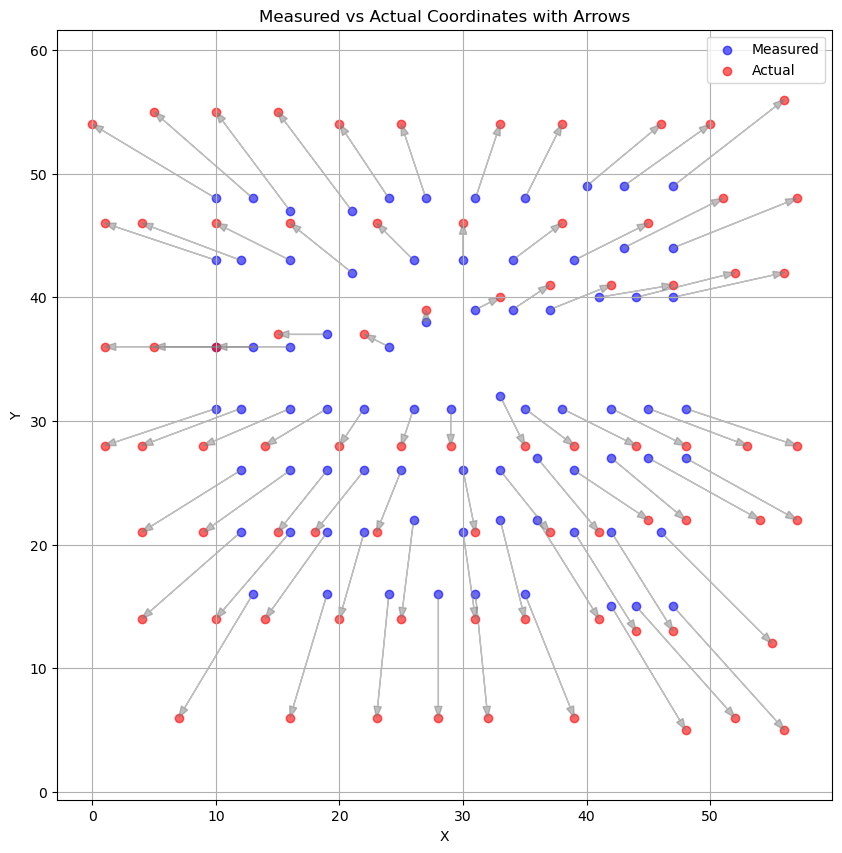

In [22]:
import matplotlib.pyplot as plt

# Your data
measured = [
    (13,16), (19,16), (24,16), (28,16), (31,16), (35,16), (42,15), (44,15), (47,15),
    (46,21), (42,21), (39,21), (36,22), (33,22), (30,21), (26,22), (22,21), (19,21), (16,21), (12,21),
    (12,26), (16,26), (19,26), (22,26), (25,26), (30,26), (33,26), (36,27), (39,26), (42,27), (45,27), (48,27),
    (48,31), (45,31), (42,31), (38,31), (35,31), (33,32), (29,31), (26,31), (22,31), (19,31), (16,31), (12,31), (10,31),
    (10,36), (13,36), (16,36), (19,37), (24,36), (27,38), (31,39), (34,39), (37,39), (41,40), (44,40), (47,40),
    (47,44), (43,44), (39,43), (34,43), (30,43), (26,43), (21,42), (16,43), (12,43), (10,43),
    (10,48), (13,48), (16,47), (21,47), (24,48), (27,48), (31,48), (35,48), (40,49), (43,49), (47,49)
]

actual = [
    (7,6), (16,6), (23,6), (28,6), (32,6), (39,6), (48,5), (52,6), (56,5),
    (55,12), (47,13), (44,13), (41,14), (35,14), (31,14), (25,14), (20,14), (14,14), (10,14), (4,14),
    (4,21), (9,21), (15,21), (18,21), (23,21), (31,21), (37,21), (41,21), (45,22), (48,22), (54,22), (57,22),
    (57,28), (53,28), (48,28), (44,28), (39,28), (35,28), (29,28), (25,28), (20,28), (14,28), (9,28), (4,28), (1,28),
    (1,36), (5,36), (10,36), (15,37), (22,37), (27,39), (33,40), (37,41), (42,41), (47,41), (52,42), (56,42),
    (57,48), (51,48), (45,46), (38,46), (30,46), (23,46), (16,46), (10,46), (4,46), (1,46),
    (0,54), (5,55), (10,55), (15,55), (20,54), (25,54), (33,54), (38,54), (46,54), (50,54), (56,56)
]

# Unpack data
measured_x, measured_y = zip(*measured)
actual_x, actual_y = zip(*actual)

# Plot points
plt.figure(figsize=(10, 10))
plt.scatter(measured_x, measured_y, color='blue', label='Measured', alpha=0.6)
plt.scatter(actual_x, actual_y, color='red', label='Actual', alpha=0.6)

# Draw arrows
for (mx, my), (ax, ay) in zip(measured, actual):
    dx = ax - mx
    dy = ay - my
    plt.arrow(mx, my, dx, dy, color='gray', alpha=0.5, head_width=0.6, length_includes_head=True)

# Labels and display
plt.title("Measured vs Actual Coordinates with Arrows")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()


In [26]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Step 1: Prepare your data
# Replace with your actual data
measured = np.array([
    [13,16], [19,16], [24,16], [28,16], [31,16], [35,16], [42,15], [44,15], [47,15],
    [46,21], [42,21], [39,21], [36,22], [33,22], [30,21], [26,22], [22,21], [19,21], [16,21], [12,21],
    [12,26], [16,26], [19,26], [22,26], [25,26], [30,26], [33,26], [36,27], [39,26], [42,27], [45,27], [48,27],
    [48,31], [45,31], [42,31], [38,31], [35,31], [33,32], [29,31], [26,31], [22,31], [19,31], [16,31], [12,31], [10,31],
    [10,36], [13,36], [16,36], [19,37], [24,36], [27,38], [31,39], [34,39], [37,39], [41,40], [44,40], [47,40],
    [47,44], [43,44], [39,43], [34,43], [30,43], [26,43], [21,42], [16,43], [12,43], [10,43],
    [10,48], [13,48], [16,47], [21,47], [24,48], [27,48], [31,48], [35,48], [40,49], [43,49], [47,49]
])

actual = np.array([
    [7,6], [16,6], [23,6], [28,6], [32,6], [39,6], [48,5], [52,6], [56,5],
    [55,12], [47,13], [44,13], [41,14], [35,14], [31,14], [25,14], [20,14], [14,14], [10,14], [4,14],
    [4,21], [9,21], [15,21], [18,21], [23,21], [31,21], [37,21], [41,21], [45,22], [48,22], [54,22], [57,22],
    [57,28], [53,28], [48,28], [44,28], [39,28], [35,28], [29,28], [25,28], [20,28], [14,28], [9,28], [4,28], [1,28],
    [1,36], [5,36], [10,36], [15,37], [22,37], [27,39], [33,40], [37,41], [42,41], [47,41], [52,42], [56,42],
    [57,48], [51,48], [45,46], [38,46], [30,46], [23,46], [16,46], [10,46], [4,46], [1,46],
    [0,54], [5,55], [10,55], [15,55], [20,54], [25,54], [33,54], [38,54], [46,54], [50,54], [56,56]
])

# Step 2: Fit 2D polynomial model
degree = 3  # Try degree=2 or 3; adjust for overfitting/underfitting
poly = PolynomialFeatures(degree=degree)

# Transform inputs
X_poly = poly.fit_transform(measured)

# Fit separate regressions for x and y
model_x = LinearRegression().fit(X_poly, actual[:, 0])
model_y = LinearRegression().fit(X_poly, actual[:, 1])

# Step 3: Define prediction function
def correct_position(measured_x, measured_y):
    input_poly = poly.transform([[measured_x, measured_y]])
    corrected_x = model_x.predict(input_poly)[0]
    corrected_y = model_y.predict(input_poly)[0]
    return corrected_x, corrected_y

# Example usage
pred_x, pred_y = correct_position(22, 26)
print("Corrected:", round(pred_x, 2), round(pred_y, 2))


Corrected: 18.8 20.86


# Noter

In [ ]:
[('orange', (14, 29)), ('white', (40, 39)), ('white', (30, 40)), ('white', (15, 35)), ('white', (43, 19)), ('white', (22, 17)), ('white', (36, 20))]






measured_x_calibration = [
    (6, 10),   #If the target is 10 then the actual position should be 6 
    (10.5, 14), 
    (15, 18), 
    (20, 22), 
    (25, 26), 
    (29, 30), 
    (33, 33), 
    (37, 36), 
    (42, 40), 
    (47, 44), 
    (51, 48), 
]  


            # Draw red dots at the corners
            for corner_name, corner_coords in corners.items():
                cv2.circle(new_frame, (int(corner_coords[0]), int(corner_coords[1])), 7, (0, 255, 255), -1)  # Red filled circle

            # Draw grid
            for i in range(1, num_cells):
                x = min_x + i * cell_width
                y = min_y + i * cell_height
                cv2.line(new_frame, (int(x), int(min_y)), (int(x), int(max_y)), (255, 255, 255), 1)
                cv2.line(new_frame, (int(min_x), int(y)), (int(max_x), int(y)), (255, 255, 255), 1)

            # Draw rectangle around the field
            cv2.rectangle(new_frame, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (0, 0, 0), 2)


elif key == ord('t'):   # move 1 step towards target pos=50
    x_pos += move_one_step_towards_target(x_blue, 50)
    command = f"G1 X{x_pos} Y{x_pos} F300\n".encode()
    ser.write(command)

elif key == ord('y'):  
    x_pos = update_x_pos(x_blue, target_x, x_pos)
    command = f"G1 X{x_pos} Y{x_pos} F300\n".encode()
    ser.write(command)


elif key == ord('m'):
    if len(blue_positions) == 1:
        timing_start_pos = blue_positions[0][0]
        x_pos += 50  # Move 50 motor steps
        command = f"G1 X{x_pos} Y{x_pos} F300\n".encode()
        ser.write(command)

        measuring_motion = True
        timing_start_time = time.time()
        last_blue_x = timing_start_pos
        stability_count = 0
        last_check_time = time.time()
        print(f"[TIMING TEST STARTED] Moving 50 steps from {timing_start_pos}")


if measuring_motion:
            current_time = time.time()

            if current_time - last_check_time >= check_interval:
                last_check_time = current_time

                if abs(x_blue - last_blue_x) < stability_threshold:
                    stability_count += 1
                else:
                    stability_count = 0  # Reset if movement continues

                last_blue_x = x_blue

                if stability_count >= required_stability:
                    duration = current_time - timing_start_time
                    total_movement = x_blue - timing_start_pos
                    speed = total_movement / duration if duration > 0 else 0

                    print(f"[TIMING COMPLETE]")
                    print(f"Time taken: {duration:.2f} seconds")
                    print(f"Moved: {total_movement:.2f} visual units")
                    print(f"Speed: {speed:.2f} units/sec")

                    measuring_motion = False

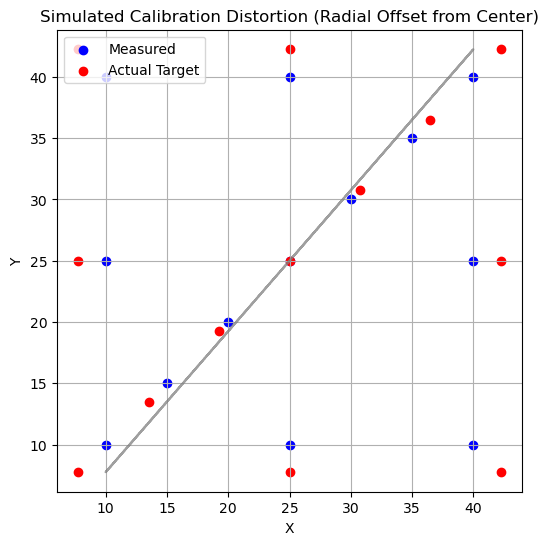

In [45]:
# Center of field
center_x = 25
center_y = 25

# Simulated measured points
measured_x_calibration = [
    (10, 10),
    (15, 15),
    (20, 20),
    (25, 25),  # center: no distortion
    (30, 30),
    (35, 35),
    (40, 40),
    (10, 40),
    (40, 10),
    (25, 10),
    (25, 40),
    (10, 25),
    (40, 25)
]

# Corresponding actual (target) positions – further from center
target_x_calibration = []
for mx, my in measured_x_calibration:
    # Vector from center to measured
    dx = mx - center_x
    dy = my - center_y

    # Increase offset based on distance from center (simple radial scaling)
    scale = 1.15  # simulate ~15% distortion
    tx = center_x + dx * scale
    ty = center_y + dy * scale

    target_x_calibration.append((tx, ty))

import matplotlib.pyplot as plt

# Split into X and Y for plotting
measured_x, measured_y = zip(*measured_x_calibration)
target_x, target_y = zip(*target_x_calibration)

plt.figure(figsize=(6, 6))
plt.scatter(measured_x, measured_y, label="Measured", color='blue')
plt.scatter(target_x, target_y, label="Actual Target", color='red')
plt.plot([m[0] for m in measured_x_calibration], [t[0] for t in target_x_calibration], 'gray', linestyle='--', alpha=0.5)
plt.plot([m[1] for m in measured_x_calibration], [t[1] for t in target_x_calibration], 'gray', linestyle='--', alpha=0.5)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.title("Simulated Calibration Distortion (Radial Offset from Center)")
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Your observed data
# Format: (actual_position, measured_position)
measured_x_calibration = [
    (6, 10),   #If the target is 10 then the actual position should be 6 
    (10.5, 14), 
    (15, 18), 
    (20, 22), 
    (25, 26), 
    (29, 30), 
    (33, 33), 
    (37, 36), 
    (42, 40), 
    (47, 44), 
    (51, 48), 
]  

# Split the data into inputs (measured) and outputs (actual)
actual_positions_x_calibration = np.array([a for a, m in measured_x_calibration])
measured_positions_x_calibration = np.array([m for a, m in measured_x_calibration]).reshape(-1, 1)

# Use polynomial regression (degree 2 gives good balance of flexibility and overfitting)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(measured_positions_x_calibration)
model = LinearRegression().fit(X_poly, actual_positions_x_calibration)

# Correction function
def correct_position_x(measured_value):
    measured_poly = poly.transform(np.array([[measured_value]]))
    return model.predict(measured_poly)[0]

# Example usage
test_value = 10
corrected = correct_position_x(test_value)
print(f"Measured: {test_value} -> Corrected: {corrected:.2f}")


Measured: 10 -> Corrected: 5.84
